# 日経平均と先物 2 分足 先物が先行指標になっているか？

In [47]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [53]:
import datetime

from matplotlib import (
    dates as mdates,
    font_manager as fm,
    pyplot as plt,
)
import mplfinance as mpf
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

In [113]:
def getMajorXTicks(df: pd.DataFrame) -> tuple:
    date_str = str(df.index[0].date())
    tick_labels = [
        '9:00', '9:30',
        '10:00', '10:30',
        '11:00', '11:30',
        '12:30',
        '13:00', '13:30',
        '14:00', '14:30',
        '15:00', '15:30'
    ]
    tick_position = [pd.to_datetime('%s %s' % (date_str, l)) for l in tick_labels]

    return tick_position, tick_labels

In [114]:
code1 = 'N225'
symbol1 = '^%s' % code1
ticker1 = yf.Ticker(symbol1)

code2 = 'NIY=F'
symbol2 = '%s' % code2
ticker2 = yf.Ticker(symbol2)

In [115]:
# 先物
df1 = ticker1.history(period='1d', interval='2m')
df1.index = df1.index.tz_localize(None)
df1

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-04-15 09:00:00,34349.011719,34360.781250,34316.378906,34339.300781,0,0.0,0.0
2025-04-15 09:02:00,34347.480469,34408.140625,34327.750000,34404.019531,0,0.0,0.0
2025-04-15 09:04:00,34389.039062,34399.578125,34344.921875,34344.921875,0,0.0,0.0
2025-04-15 09:06:00,34348.710938,34358.101562,34331.210938,34354.039062,0,0.0,0.0
2025-04-15 09:08:00,34352.660156,34373.441406,34327.140625,34334.859375,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-04-15 15:20:00,34286.960938,34289.078125,34266.308594,34283.441406,0,0.0,0.0
2025-04-15 15:22:00,34287.101562,34310.828125,34285.628906,34287.859375,0,0.0,0.0
2025-04-15 15:24:00,34289.929688,34299.238281,34282.050781,34283.910156,0,0.0,0.0


In [116]:
# 先物
df2 = ticker2.history(period='2d', interval='2m')
df2.index = df2.index.tz_convert('Asia/Tokyo')
df2.index = df2.index.tz_localize(None)
df2

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-04-14 13:00:00,34165.0,34185.0,34165.0,34180.0,8,0.0,0.0
2025-04-14 13:02:00,34185.0,34200.0,34185.0,34200.0,3,0.0,0.0
2025-04-14 13:04:00,34200.0,34225.0,34200.0,34225.0,48,0.0,0.0
2025-04-14 13:06:00,34220.0,34220.0,34210.0,34210.0,4,0.0,0.0
2025-04-14 13:08:00,34205.0,34205.0,34180.0,34200.0,61,0.0,0.0
...,...,...,...,...,...,...,...
2025-04-15 19:24:00,34385.0,34395.0,34385.0,34390.0,10,0.0,0.0
2025-04-15 19:26:00,34385.0,34390.0,34385.0,34385.0,4,0.0,0.0
2025-04-15 19:28:00,34375.0,34375.0,34375.0,34375.0,1,0.0,0.0


## 終値をプロット

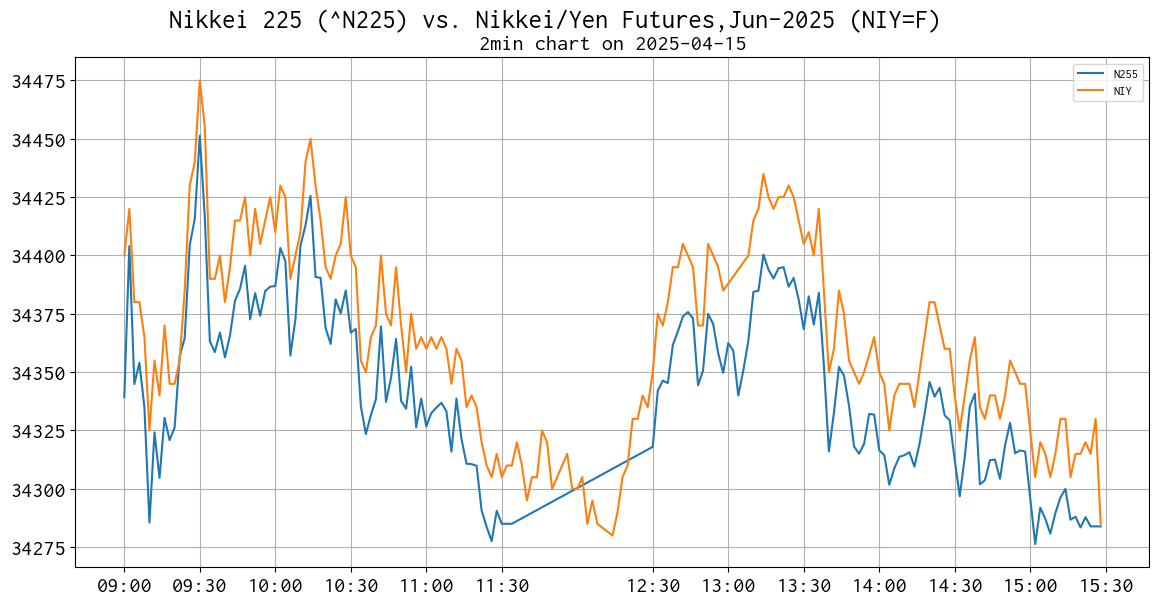

In [117]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df1['Close'], label='N255')
t1 = df1.index[0]
t2 = df1.index[len(df1) - 1]
ax.plot(df2.loc[[t for t in df2.index if t1 <= t <= t2]]['Close'], label='NIY')

tick_position, tick_labels = getMajorXTicks(df1)
ax.set_xticks(ticks=tick_position, labels=tick_labels,)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.legend(loc='best', fontsize=9)
ax.grid()

dt = df1.index[0]
ax.set_title('2min chart on {:0=4}-{:0=2}-{:0=2}'.format(dt.year, dt.month, dt.day), fontsize=16)
             
plt.suptitle('%s (%s) vs. %s (%s)' % (ticker1.info['shortName'], symbol1, ticker2.info['shortName'], symbol2))
plt.subplots_adjust(left=0.1, right=0.995, bottom=0.05, top=0.9)
plt.savefig('report_2m_chart_n255_niy.png')
plt.show()